In [716]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(linewidth=150)
pd.set_option('display.max_columns', 500)

In [717]:
log1 = open("model_testbed.log","r").read()
log2 = open("logs/model_testbed.log","r").read()
log = log1+log2
outs = log.split("NEW MODEL ")[1:]


def line_format(line,add_quotes=True):
    if ("INFO" not in line or 'cell:' in line) and "[" in line and "]" in line:
        if "," not in line:
            if "." in line:
                line = re.sub('(?<=\d)\.+',",",line)
            else:
                line = re.sub('(?<=\d)\s+',",",line)
    if "torch.utils.data" in line:
        line = line.replace("<","'").replace(">","'")
            
            
    line = line.replace("\n","").replace(" ","").replace("array","np.array").replace("\e[1m","").replace("\e[21mN","")
    if add_quotes:
        if ":" in line:
            name,val = line.split(":",1)
            if name=='prefix':
                return '"{}":"{}"'.format(name.strip(),val)
            else:
                return '"{}":{}'.format(name.strip(),val)
    return line


def general_stats(line,current,start_cond,end_cond,stats_str):
    if start_cond in line:
        current = start_cond
        stats_str = line_format(line.split("stats:")[-1],False)
    elif current == start_cond:
        if end_cond in line:
            current = ''
            return True,"{}".format(stats_str),current

        else:
            stats_str += '{}'.format(line_format(line,False))
    return False,stats_str,current
            
def specific_stats(line,current,start_cond,end_cond,stats_str=""):
    #print(current,[(x,line,x in line) for x in end_cond])
    if start_cond in line:
        current = start_cond
        stats_str = ""
    
    elif current == start_cond:
        if any([x in line for x in end_cond]):
            current = ''
            return True,"{{{}}}".format(stats_str.rsplit(",",1)[0]),current
        elif line[-1]==",":
            #print("pre add ",stats_str)
            stats_str += '{}'.format(line_format(line.split("run:")[-1]))
            #print("post add",stats_str)
        else:
            #print("pre add ",stats_str)
            stats_str += '{}, '.format(line_format(line.split("run:")[-1]))
            #print("post add",stats_str)
    return False,stats_str,current

In [718]:
runs = []
for i,out in enumerate(outs):
    print(i,end="\r")
    curve = []
    predictions = []
    current = None
    time_taken = None
    max_val = None
    early_terminate=False
    stats_str = ""
    epoch_time = None
    run_date = None
    
    general_model_stats,general_run_stats,specific_model_stats,specific_run_stats = {},{},{},{}
    #print("--LOOP ENTER--")
    for line in out.split('\n'):
        #print(line)
        if line=="" or ('Loss' in line and 'Corrects' not in line and 'Epoch: 0' not in line):
            pass
        else:
            
            finished,stats_str,current = general_stats(line,current,'Model stats:','Run stats:',stats_str)
            if finished:
                exec("general_model_stats={}".format(stats_str))
                stats_str = ""
                finished = False
                
            finished,stats_str,current = general_stats(line,current,'Run stats:','=====',stats_str)
            if finished:
                exec("general_run_stats={}".format(stats_str))
                stats_str = ""
                finished = False
            
            finished,stats_str,current = specific_stats(line,current,'-- Model stats',[' Run stats '],stats_str)
            if finished:
                exec("specific_model_stats={}".format(stats_str))
                stats_str = ""
                finished = False
            
            if not specific_run_stats:
                finished,stats_str,current = specific_stats(line,current,' Run stats ',['====',"Per epoch","Run finished","Train Epoch: 0"],stats_str)
                if finished:
                    #print("RUN FINISHED")
                    exec("specific_run_stats={}".format(stats_str))
                    stats_str = ""
                    finished = False
            
            if "Corrects" in line:
                curve.append(int(line.split(":")[-1].split("/")[0]))
            if "Prediction" in line:
                if "[[" in line:
                    predictions.append(float(line.split("[[")[-1].split("]]")[0]))
                elif "," in line:
                    predictions.append(float(line.split(":")[-1].split(",")[0]))
                else:
                    predictions.append(float(line.split(":")[-1]))
            if "Time taken" in line:
                time_taken = line.split(":")[-1]
            if "terminated" in line.lower():
                early_terminate=True
            if 'Run started' in line:
                run_date = line.split("at ")[-1]
            if 'Max corrects' in line:
                max_val = int(line.split(":")[-1].split("/")[0])
            if 'Per epoch time' in line:
                epoch_time = line.split(":")[-1].strip()
    #print("--LOOP EXIT--")
    
    stats = {}
    if general_run_stats:
        stats.update(general_run_stats)
    if general_model_stats:
        stats.update(general_model_stats)
    if specific_run_stats:
        stats.update(specific_run_stats)
    if specific_model_stats:
        stats.update(specific_model_stats)
    
    for key in stats.keys():
        new_key = key.strip().replace('matrix','matrices')
        #print(key)
        if key=='cell':
            new_key='cell_matrices'
        if key=='momemtum':
            new_key = 'momentum'
        if new_key!=key:
            stats[new_key] = stats.pop(key)
        
    stats['curve']=curve
    stats['predictions']=predictions
    stats['epoch']=len(curve)
    stats['time_taken']=time_taken
    stats['early_terminate']=early_terminate
    stats['per_epoch_time']=epoch_time
    if not max_val:
        stats['max']=max(curve) if len(curve)>0 else None
    else:
        stats['max']=max_val
    stats['run_date']=run_date
    runs.append(stats)
    
run_stats = pd.DataFrame(runs)
#run_stats.sort_values('max',ascending=False)
run_stats

,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay
0,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[2512, 4414, 4551, 5161, 5186, 5298, 5543, 581...",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",5813.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","3 min, 15 s",NaN,NaN,True,0.0001
1,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3840, 3939, 4431]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4431.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","1 min, 0 s",NaN,NaN,True,0.0001
2,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[2376, 3827, 4112]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4112.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","1 min, 1 s",NaN,NaN,True,0.0001
3,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[4113, 4653]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,2,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4653.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
4,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
5,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
6,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
7,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
8,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3849, 4024, 4326]",NaN,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4326.0,0.9,9490918.0,None,[],NaN,NaN,2018-10-29 13:38:42,2.0,"(1.0, 1.0)","1 min, 1 s",NaN,NaN,True,0.0001
9,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3723, 4252]",NaN,NaN,False,2,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4252.0,0.9,9490918.0,None,[],NaN,NaN,2018-10-29 13:39:58,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001


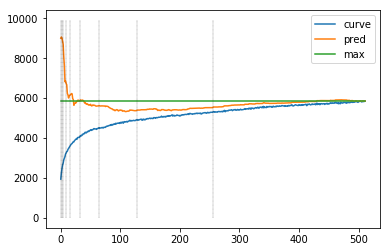

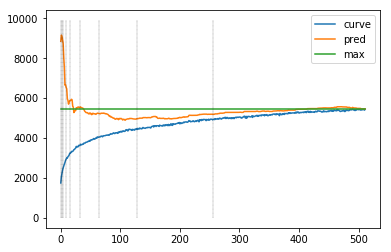

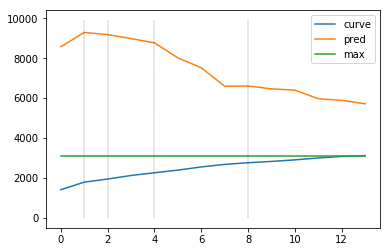

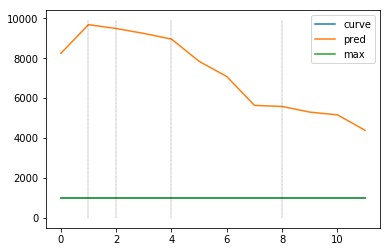

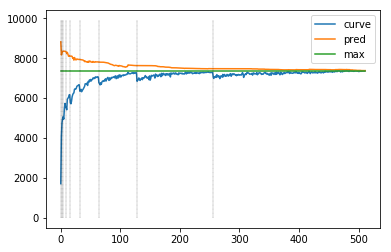

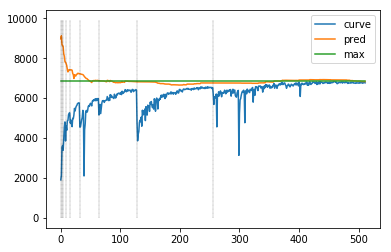

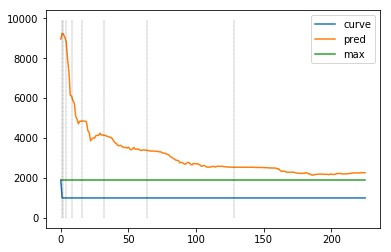

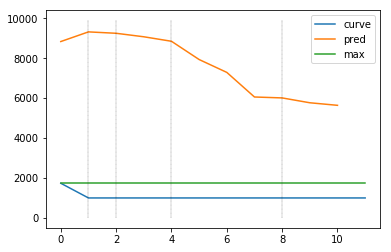

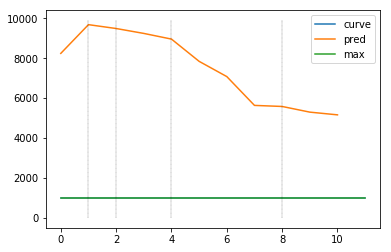

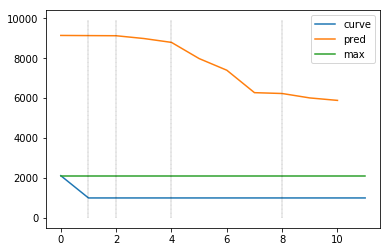

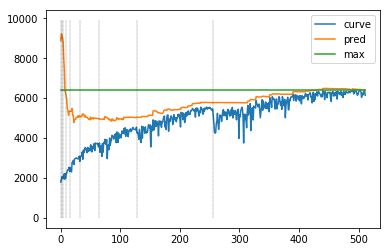

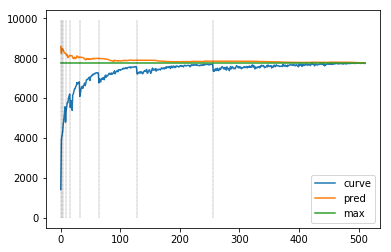

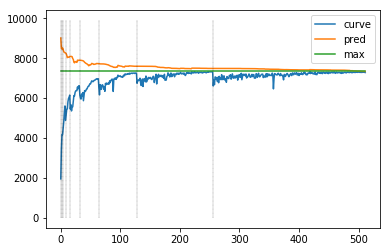

In [721]:
val_preds = run_stats[[len(x)>8 for x in run_stats['predictions']]]
for idx,pred in val_preds.iterrows():
    plt.plot(pred['curve'],label='curve')
    plt.plot(pred['predictions'],label='pred')
    plt.plot([pred['max']]*len(pred['curve']),label='max')
    for i in range(10):
        if 2**i<len(pred['curve']):
            plt.plot([2**i]*100,
                     np.arange(0,10000,100),
                     c='k',
                     linewidth=.25,
                     linestyle="--")
    plt.legend()
    plt.show()

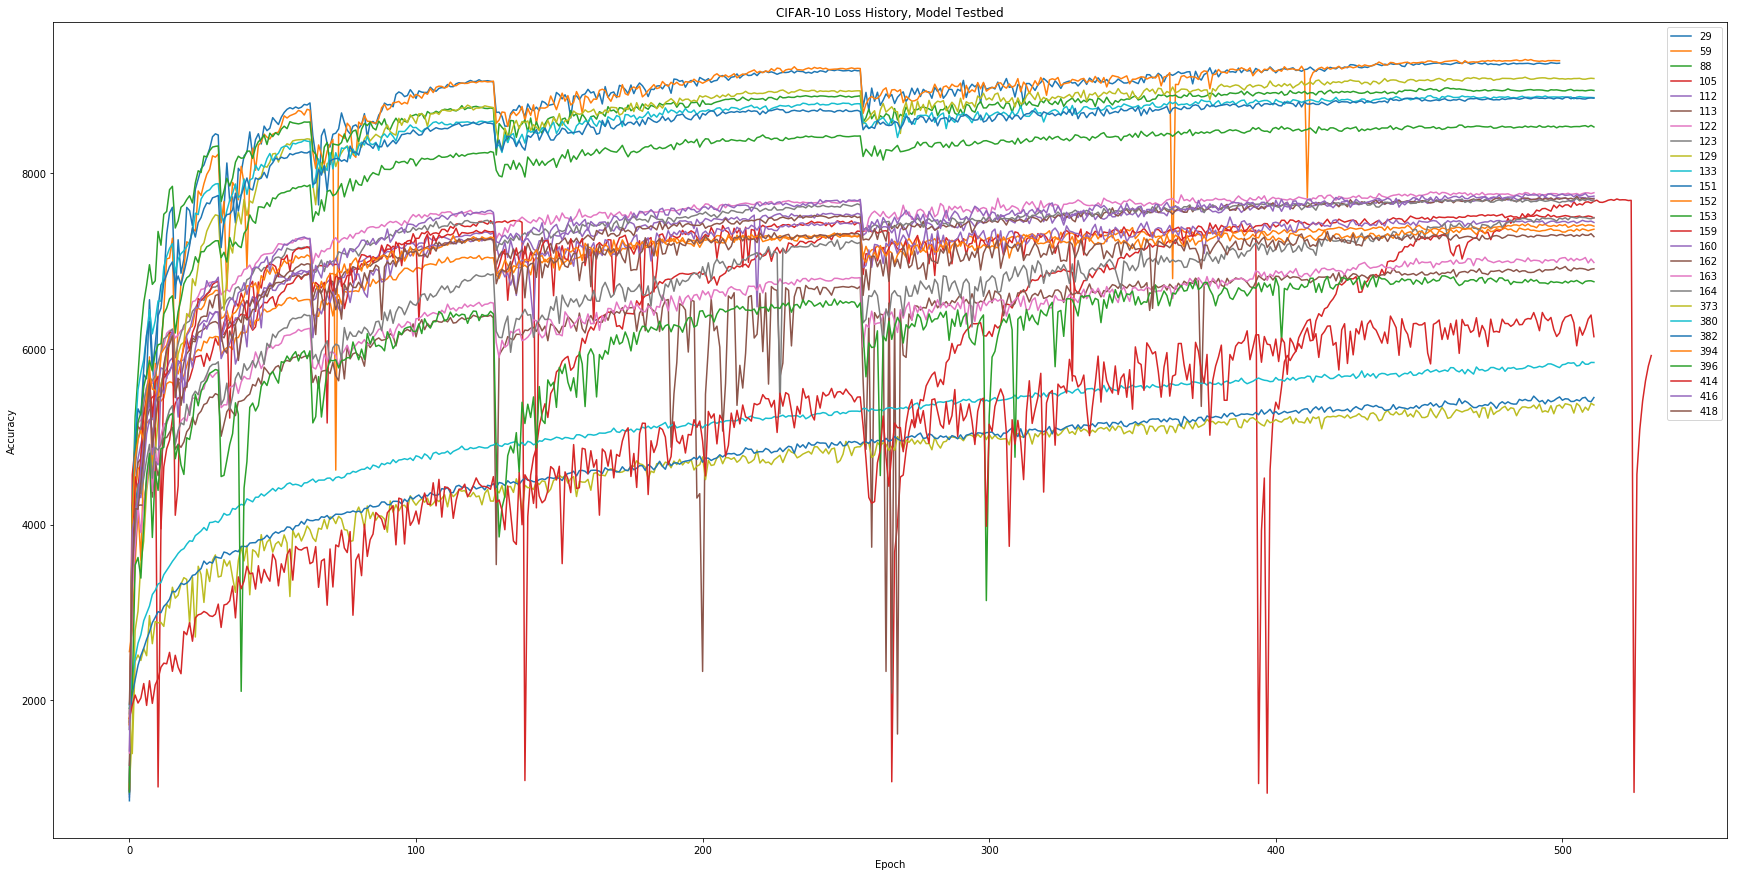

In [731]:
plt.figure(figsize=(30,15))
for i,curve in enumerate(run_stats['curve']):
    if len(curve)>=500:
        plt.plot(curve,label=i)
plt.title("CIFAR-10 Loss History, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [726]:
losses = run_stats['curve'][run_stats['epoch']>=500]
losses = [x[:512] if len(x)>512 else x for x in losses]
losses = [x if len(x)==512 else x+x[-1:]*12 for x in losses]
losses = np.array(losses)
train_size = int(losses.shape[0]*.75)
print(losses.shape,train_size)

(26, 512) 19


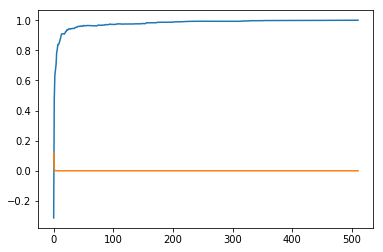

0 (-0.31319324042699115, 0.11924990288418014)
10 (0.8579340792045308, 2.119772136836679e-08)
20 (0.9234170247972908, 1.8094200271601772e-11)
30 (0.9432448015835065, 5.508544786322806e-13)
40 (0.9568059230152481, 2.23162681524336e-14)
50 (0.9652311119571174, 1.7247115950997894e-15)
60 (0.9638474188190526, 2.7352693312873383e-15)
70 (0.9628864166490618, 3.728807478495906e-15)
80 (0.9665990757642023, 1.0729762063700952e-15)
90 (0.9704999687514121, 2.466481447574106e-16)
100 (0.9721861604875006, 1.2277334476178182e-16)
110 (0.9759015821929643, 2.239341878738652e-17)
120 (0.9751036056570241, 3.2969864890797796e-17)
130 (0.9755731699442567, 2.6298535775217678e-17)
140 (0.9762450769498939, 1.888282136539916e-17)
150 (0.9777597204329631, 8.631365319325419e-18)
160 (0.9828619251261711, 3.8840754377940305e-19)
170 (0.9827681072547189, 4.145057976366487e-19)
180 (0.9868001628944433, 1.7270580706999505e-20)
190 (0.9868981588210443, 1.5801173996537128e-20)
200 (0.9878171480376333, 6.633250933643260

In [724]:
from scipy.stats import pearsonr

maxes = np.max(losses,1)
up_to_max = np.array([np.max(losses[:,:x],1) for x in range(1,losses.shape[1])])
corrs = [pearsonr(x,maxes) for x in up_to_max]
plt.plot(corrs)
plt.show()

for i,corr in enumerate(corrs):
    if not i%10:
        print(i,corr)

In [730]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import pickle as pkl

train_x,test_x = up_to_max[:,:train_size],up_to_max[:,train_size:]
train_y,test_y = maxes[:train_size],maxes[train_size:]
funcs = {}
pearsons = []
print(train_x.shape)
for i in range(train_x.shape[0]):
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X=train_x[i].reshape(-1,1),y=train_y.reshape(-1,1))
    pred = regr.predict(test_x[i].reshape(-1,1))
    pearson = pearsonr(train_x[i],train_y)
    pearsons.append(pearson)
    funcs[i] = {'b':regr.intercept_,'m':regr.coef_,'pearson':pearson[0]}
    
    if not i%50:
        print("=={}==".format(i))
        print("C_{:<3}: {}".format(i,test_x[i]))
        print("P_512:",np.array([int(x[0]) for x in pred]))
        print("A_512:",test_y)
        print("PearsonR: {:.3f},{:.3f}".format(*pearson))
        print("Mean squared error: %.2f" % mean_squared_error(test_x[i], pred))
        
pkl.dump(funcs,open('loss_predictors.pkl',"wb"))

(511, 19)
==0==
C_0  : [1943 1751 1717 1906 1792 1421 1955]
P_512: [7873 7894 7898 7877 7889 7930 7872]
A_512: [5857 5463 7378 6833 6416 7771 7339]
PearsonR: -0.051,0.834
Mean squared error: 37334485.72
==50==
C_50 : [4411 3891 6934 5766 3664 7051 6723]
P_512: [5760 5330 7845 6879 5142 7941 7670]
A_512: [5857 5463 7378 6833 6416 7771 7339]
PearsonR: 0.988,0.000
Mean squared error: 1406067.55
==100==
C_100: [4783 4318 7164 6253 4301 7422 7151]
P_512: [5672 5278 7690 6918 5264 7909 7679]
A_512: [5857 5463 7378 6833 6416 7771 7339]
PearsonR: 0.990,0.000
Mean squared error: 554299.60
==150==
C_150: [4995 4538 7294 6432 4664 7579 7259]
P_512: [5664 5263 7683 6926 5374 7933 7652]
A_512: [5857 5463 7378 6833 6416 7771 7339]
PearsonR: 0.994,0.000
Mean squared error: 308075.35
==200==
C_200: [5163 4780 7294 6436 5195 7615 7267]
P_512: [5650 5303 7580 6803 5679 7870 7555]
A_512: [5857 5463 7378 6833 6416 7771 7339]
PearsonR: 0.995,0.000
Mean squared error: 158988.73
==250==
C_250: [5287 4944 731